# Optics simulation with tensor networks

This notebook demonstrates the use of Optyx for simulating various quantum photonic observables, comparing its results with those obtained using Quandela's Perceval.

The focus is on explaining the package interface and contrasting it with traditional permanent-based methods for calculating observables. We highlight how Optyx’s tensor network-based approach maintains simplicity of the interface as the complexity of the observables increases, whereas permanent-based methods require specific adjustments for more intricate calculations.

We begin with the example of Fock basis states as both inputs and outputs, a common scenario for permanent-based methods. Next, we explore a more challenging case using an entangled GHZ state as the input. In this scenario, permanent-based methods necessitate summing over all Fock basis states to compute amplitudes or probabilities. For calculating the complete output probability distribution across all Fock basis states, permanent-based methods, from the stand-point of the experimenter, work the same as in the case of a single amplitude.

The advantage of tensor network-based methods becomes evident when calculating expected values of circuits involving number operators. Permanent-based approaches require matrix dilation and tracking input photon counts, adding significant complexity. In contrast, Optyx’s tensor-based framework automatically constructs the tensor network for any circuit configuration. Users can simply compose the circuit from elementary generators and contract the tensor network to obtain results, streamlining the process even for complex circuits.

## Setup

In [1]:
import discopy
discopy.__path__

['/home/mateusz/.local/lib/python3.10/site-packages/discopy']

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import perceval as pcvl
import timeit
import optyx.zw as zw
import optyx.lo as circuit
from optyx import zx
import pandas as pd

In [4]:
import sympy as sp
from optyx import lo

def ansatz_bs(width, depth):

    def p(i, j):
        return sp.Symbol(f"a_{i}_{j}")

    d = lo.Id(width)
    for i in range(depth):
        n_mzi = (width - 1) // 2 if i % 2 else width // 2
        left = lo.Id(i % 2)
        right = lo.Id(width - len(left.dom) - 2 * n_mzi)
        d >>= left.tensor(*[lo.BBS(p(i, j)) for j in range(n_mzi)]) @ right

    return d


# this function is used to convert a matrix to a linear optical circuit
def umatrix_to_perceval_circuit(matrix) -> pcvl.Circuit:
    _mzi_triangle = (
        pcvl.Circuit(2)
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_1")))
        // pcvl.BS()
        // (0, pcvl.PS(phi=pcvl.Parameter("phi_2")))
    )

    m = pcvl.Matrix(matrix.array.T)
    return pcvl.Circuit.decomposition(
        m,
        _mzi_triangle,
        phase_shifter_fn=pcvl.PS,
        shape="triangle",
        max_try=100
    ) 

In [5]:
def chip_mzi(w, l):
    ansatz = circuit.ansatz(w, l)
    symbs = list(ansatz.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz.subs(*s)

def chip_bbs(w, l):
    ansatz = ansatz_bs(w, l)
    symbs = list(ansatz.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz.subs(*s)

In [6]:
results_df = pd.DataFrame(columns=['experiment', 'mzi/bbs ansatz', 'width', 'depth', 'optyx_time', 'perceval_time', 'n_runs'])

## Full output distribution

In [7]:
#redefine the function to calculate the distribution over all Fock states
def eval_perceval_circuit_dist(circuit, 
                          input_state):

    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(circuit)
    return sim.probs(input_state)

#unfortunately, the outputs from Perceval and Optyx are not in the same order
#define a utility function to check if the output is the same
def ensure_lists_have_same_elements(list1, list2):
    list1 = np.round(list1, 4)
    list2 = np.round(list2, 4)
    #remove 0 elements
    list1 = list1[np.where(list1 > 0)]
    list2 = list2[np.where(list2 > 0)]

    if len(list1) != len(list2):
        return False
    for i in list1:
        found_match = False
        for j in list2:
            if np.allclose(i, j):
                found_match = True
                break
        if not found_match:
            return False   
    return True

In [8]:
# get all circuits with width + depth = 15
benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(1, 11) for y in range(1, 11-x)]
benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(1, 11) for y in range(1, 11-x)]

### A bosonic product state as an input

In [9]:
number_of_runs = 5

In [10]:
for U, w, l in benchmark_circuits_mzi:
    print(f"Running experiment for mzi ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w

    input_state = [1] * n_modes

    #set up a random chip
    U_matrix = U.to_path()

    #calculate probability using Perceval
    pcvl_input_state = pcvl.BasicState(input_state)
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_input_state = zw.Create(*input_state)
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons+1)
    contract = tensor.to_quimb() ^ ...
    zw_prob = np.abs((contract).data)**2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]   

    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)

    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=number_of_runs, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=number_of_runs, globals=globals())

    new_row = {
        'experiment': 'BPS',
        'mzi/bbs ansatz': 'mzi',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Running experiment for mzi ansatz with width 1 and depth 1


/tmp/ipykernel_385067/3836441738.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Running experiment for mzi ansatz with width 1 and depth 2
Running experiment for mzi ansatz with width 1 and depth 3
Running experiment for mzi ansatz with width 1 and depth 4
Running experiment for mzi ansatz with width 1 and depth 5
Running experiment for mzi ansatz with width 1 and depth 6
Running experiment for mzi ansatz with width 1 and depth 7
Running experiment for mzi ansatz with width 1 and depth 8
Running experiment for mzi ansatz with width 1 and depth 9
Running experiment for mzi ansatz with width 2 and depth 1
Running experiment for mzi ansatz with width 2 and depth 2
Running experiment for mzi ansatz with width 2 and depth 3
Running experiment for mzi ansatz with width 2 and depth 4
Running experiment for mzi ansatz with width 2 and depth 5
Running experiment for mzi ansatz with width 2 and depth 6
Running experiment for mzi ansatz with width 2 and depth 7
Running experiment for mzi ansatz with width 2 and depth 8
Running experiment for mzi ansatz with width 3 and depth

In [11]:
for U, w, l in benchmark_circuits_bbs:
    print(f"Running experiment for bbs ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w

    input_state = [1] * n_modes

    #set up a random chip
    U_matrix = U.to_path()

    #calculate probability using Perceval
    pcvl_input_state = pcvl.BasicState(input_state)
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_input_state = zw.Create(*input_state)
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons+1)
    contract = tensor.to_quimb() ^ ...
    zw_prob = np.abs((contract).data)**2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]   

    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)

    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=number_of_runs, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=number_of_runs, globals=globals())

    new_row = {
        'experiment': 'BPS',
        'mzi/bbs ansatz': 'bbs',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Running experiment for bbs ansatz with width 1 and depth 1
Running experiment for bbs ansatz with width 1 and depth 2
Running experiment for bbs ansatz with width 1 and depth 3
Running experiment for bbs ansatz with width 1 and depth 4
Running experiment for bbs ansatz with width 1 and depth 5
Running experiment for bbs ansatz with width 1 and depth 6
Running experiment for bbs ansatz with width 1 and depth 7
Running experiment for bbs ansatz with width 1 and depth 8
Running experiment for bbs ansatz with width 1 and depth 9
Running experiment for bbs ansatz with width 2 and depth 1
Running experiment for bbs ansatz with width 2 and depth 2
Running experiment for bbs ansatz with width 2 and depth 3
Running experiment for bbs ansatz with width 2 and depth 4
Running experiment for bbs ansatz with width 2 and depth 5
Running experiment for bbs ansatz with width 2 and depth 6
Running experiment for bbs ansatz with width 2 and depth 7
Running experiment for bbs ansatz with width 2 and depth

### Entangled GHZ state as an input

In [12]:
number_of_runs = 5

In [13]:
# get all circuits with width + depth = 15
benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(6, 11, 2) for y in range(1, 11-x, 2)]
benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(6, 11, 2) for y in range(1, 11-x, 2)]

In [14]:
for U, w, l in benchmark_circuits_mzi:
    print(f"Running experiment for mzi ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w
    n_parties = int(n_modes/2)

    U_matrix = U.to_path()

    #create the GHZ input state using dual rail encoding
    zw_input_state = zx.zx2path(zx.decomp(zx.Z(0, n_parties))).to_zw()
    #create the equivalent state using Perceval
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).ghz_state(n_parties)
    
    #calculate probability using Perceval
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons-2)
    zw_prob = (np.abs((tensor.to_quimb() ^ ...).data)**2)/2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]
    
    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)


    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=10, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=10, globals=globals())

    new_row = {
        'experiment': 'GHZ',
        'mzi/bbs ansatz': 'mzi',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Running experiment for mzi ansatz with width 6 and depth 1
Running experiment for mzi ansatz with width 6 and depth 3
Running experiment for mzi ansatz with width 8 and depth 1


In [15]:
for U, w, l in benchmark_circuits_bbs:
    print(f"Running experiment for bbs ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w
    n_parties = int(n_modes/2)

    U_matrix = U.to_path()

    #create the GHZ input state using dual rail encoding
    zw_input_state = zx.zx2path(zx.decomp(zx.Z(0, n_parties))).to_zw()
    #create the equivalent state using Perceval
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).ghz_state(n_parties)
    
    #calculate probability using Perceval
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons-2)
    zw_prob = (np.abs((tensor.to_quimb() ^ ...).data)**2)/2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]
    
    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)


    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=10, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=10, globals=globals())

    new_row = {
        'experiment': 'GHZ',
        'mzi/bbs ansatz': 'bbs',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Running experiment for bbs ansatz with width 6 and depth 1
Running experiment for bbs ansatz with width 6 and depth 3
Running experiment for bbs ansatz with width 8 and depth 1


### Linear cluster state

In [16]:
number_of_runs = 10

In [17]:
def generate_linear_cluster_state(n_parties):
    diagram = zx.Z(0, 1)
    for i in range(1, n_parties):
        layer = zx.Id(0)
        for j in range(1, i):
            layer = layer @ zx.Id(1)
        layer = layer @ (zx.Z(1, 2) >> (zx.Id(1) @ zx.H))
        diagram = diagram >> layer
    return diagram

In [18]:
import networkx as nx

def generate_networkx_linear_graph(n_vertices):
    G = nx.Graph()
    for i in range(n_vertices):
        G.add_node(i)
        if i != 0:
            G.add_edge(i, i-1)
    return G

In [19]:
# get all circuits with width + depth = 15
benchmark_circuits_mzi = [(chip_mzi(x, y), x, y) for x in range(6, 11, 2) for y in range(1, 11-x, 2)]
benchmark_circuits_bbs = [(chip_bbs(x, y), x, y) for x in range(6, 13, 2) for y in range(1, 13-x, 2)]

In [20]:
for U, w, l in benchmark_circuits_mzi:
    print(f"Running experiment for mzi ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w
    n_parties = int(n_modes/2)

    U_matrix = U.to_path()

    #create the GHZ input state using dual rail encoding
    zw_input_state = zx.zx2path(zx.decomp(generate_linear_cluster_state(n_parties))).to_zw()
    #create the equivalent state using Perceval
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).graph_state(generate_networkx_linear_graph(n_parties))
    
    #calculate probability using Perceval
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons)
    zw_prob = (np.abs((tensor.to_quimb() ^ ...).data)**2)/2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]
    
    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)


    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=10, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=10, globals=globals())

    new_row = {
        'experiment': 'Linear cluster state',
        'mzi/bbs ansatz': 'mzi',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Running experiment for mzi ansatz with width 6 and depth 1
Running experiment for mzi ansatz with width 6 and depth 3
Running experiment for mzi ansatz with width 8 and depth 1


In [21]:
for U, w, l in benchmark_circuits_bbs:
    print(f"Running experiment for bbs ansatz with width {w} and depth {l}")
    n_photons = w
    n_modes = w
    n_parties = int(n_modes/2)

    U_matrix = U.to_path()

    #create the GHZ input state using dual rail encoding
    zw_input_state = zx.zx2path(zx.decomp(generate_linear_cluster_state(n_parties))).to_zw()
    #create the equivalent state using Perceval
    pcvl_input_state = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL).graph_state(generate_networkx_linear_graph(n_parties))
    
    #calculate probability using Perceval
    perceval_circuit = umatrix_to_perceval_circuit(U_matrix)
    pcvl_prob = eval_perceval_circuit_dist(perceval_circuit, 
                                    pcvl_input_state)
    pcvl_prob = list(pcvl_prob.values())

    #calculate probability using Optyx with tensor contraction
    zw_circuit = zw_input_state >> U.to_zw()
    tensor = zw_circuit.to_tensor(max_dim=n_photons)
    zw_prob = (np.abs((tensor.to_quimb() ^ ...).data)**2)/2
    zw_prob = zw_prob[np.nonzero(np.round(zw_prob, 6))]
    
    #check that the probabilities agree
    assert ensure_lists_have_same_elements(pcvl_prob, zw_prob)


    backend = pcvl.BackendFactory.get_backend("SLOS")
    sim = pcvl.Simulator(backend)
    sim.set_circuit(perceval_circuit)

    time_optyx = timeit.timeit('tensor.to_quimb() ^ ...', number=10, globals=globals())
    time_perceval = timeit.timeit('sim.probs(pcvl_input_state)', number=10, globals=globals())

    new_row = {
        'experiment': 'Linear cluster state',
        'mzi/bbs ansatz': 'bbs',
        'depth': l,
        'optyx_time': time_optyx,
        'perceval_time': time_perceval,
        'n_runs': number_of_runs,
        'width': w,
    }

    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

Running experiment for bbs ansatz with width 6 and depth 1
Running experiment for bbs ansatz with width 6 and depth 3
Running experiment for bbs ansatz with width 6 and depth 5
Running experiment for bbs ansatz with width 8 and depth 1
Running experiment for bbs ansatz with width 8 and depth 3
Running experiment for bbs ansatz with width 10 and depth 1


In [22]:
## Save the results to a CSV file
results_df.to_csv('optyx_vs_perceval.csv')

## Plot the results

In [29]:
import seaborn as sns

In [36]:
melted_df = results_df.melt(
    id_vars=['experiment', 'mzi/bbs ansatz', 'width', 'depth', 'n_runs'], 
    value_vars=['optyx_time', 'perceval_time'], 
    var_name='framework', 
    value_name='time'
)

melted_df['framework'] = melted_df['framework'].map({'optyx_time': 'optyx', 'perceval_time': 'perceval'})

In [96]:
melted_df["time"] = melted_df["time"] / melted_df["n_runs"]

In [97]:
sns.set_theme()

import matplotlib.pyplot as plt


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot(experiment, ansatz, title):

    depths = melted_df['depth'].unique()
    alpha_map = {depth: np.interp(depth, (min(depths), max(depths)), (1.0, 0.1)) for depth in depths}

    marker_map = {"optyx": "o", "perceval": "s"} 
    color_map = {"optyx": "blue", "perceval": "orange"} 

    plt.figure(figsize=(10, 6))
    for depth in depths:
        subset = melted_df.query(f"experiment == '{experiment}' and `mzi/bbs ansatz` == '{ansatz}' and depth == @depth")
        for framework in subset['framework'].unique():
            framework_subset = subset[subset['framework'] == framework]
            sns.lineplot(
                data=framework_subset, 
                x="width", 
                y="time", 
                label=None, 
                alpha=alpha_map[depth],
                marker=marker_map[framework], 
                color=color_map[framework],
                linewidth=1.5,
            )

    framework_legend = [
        Line2D([0], [0], color="blue", marker="o", markersize=8, lw=2, label="optyx"),
        Line2D([0], [0], color="orange", marker="s", markersize=8, lw=2, label="perceval")
    ]

    depth_legend = [
        Line2D([0], [0], color="black", lw=2, alpha=alpha_map[depth], label=f"Depth {depth}") for depth in sorted(depths)
    ]

    plt.legend(handles=framework_legend + depth_legend, title="Framework and Depth", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Time")
    plt.tight_layout()
    plt.show()


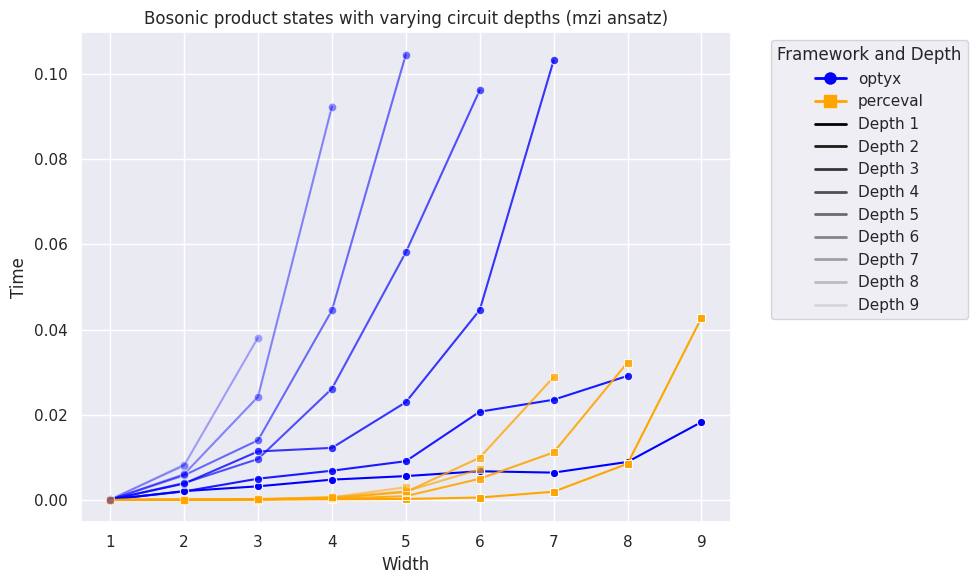

In [99]:
plot("BPS", "mzi", "Bosonic product states with varying circuit depths (mzi ansatz)")

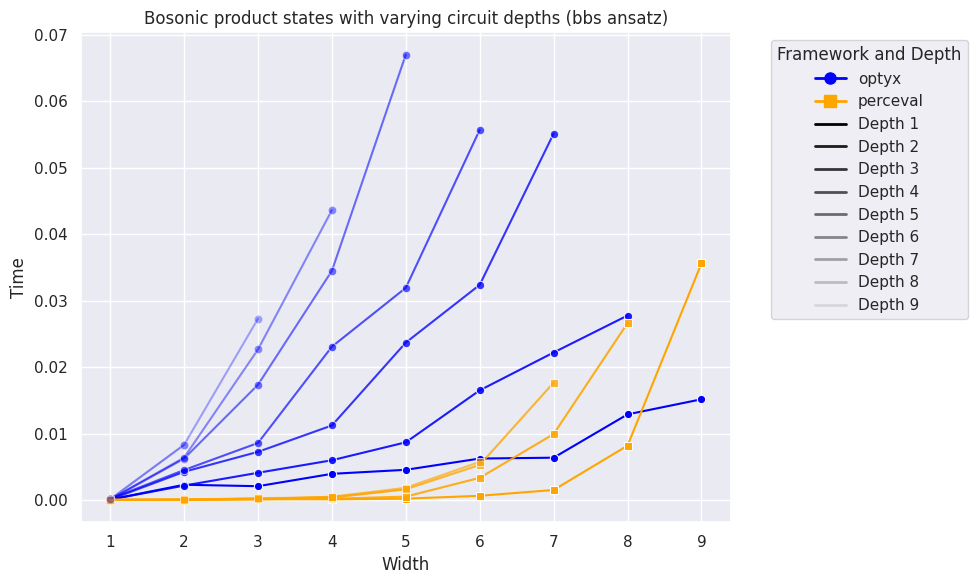

In [100]:
plot("BPS", "bbs", "Bosonic product states with varying circuit depths (bbs ansatz)")

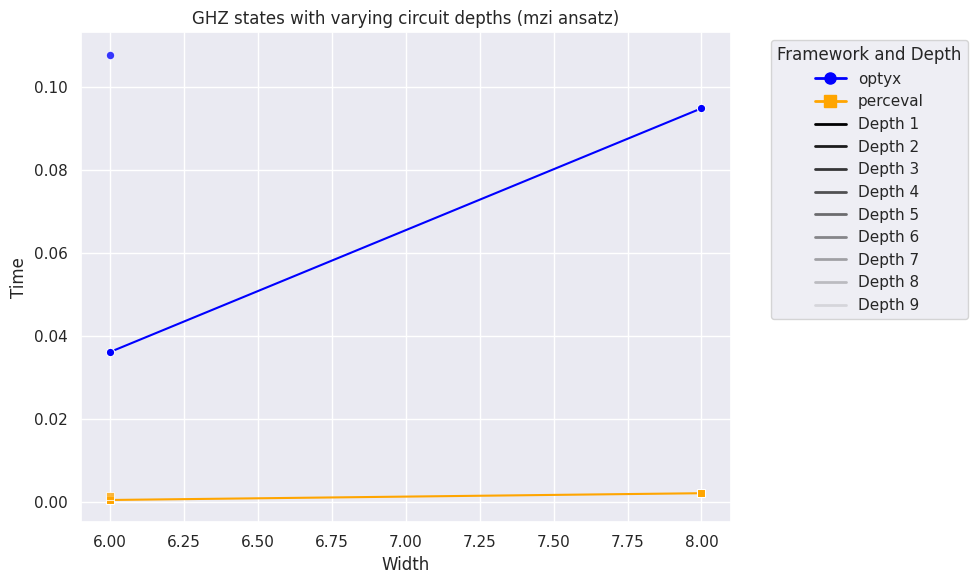

In [101]:
plot("GHZ", "mzi", "GHZ states with varying circuit depths (mzi ansatz)")

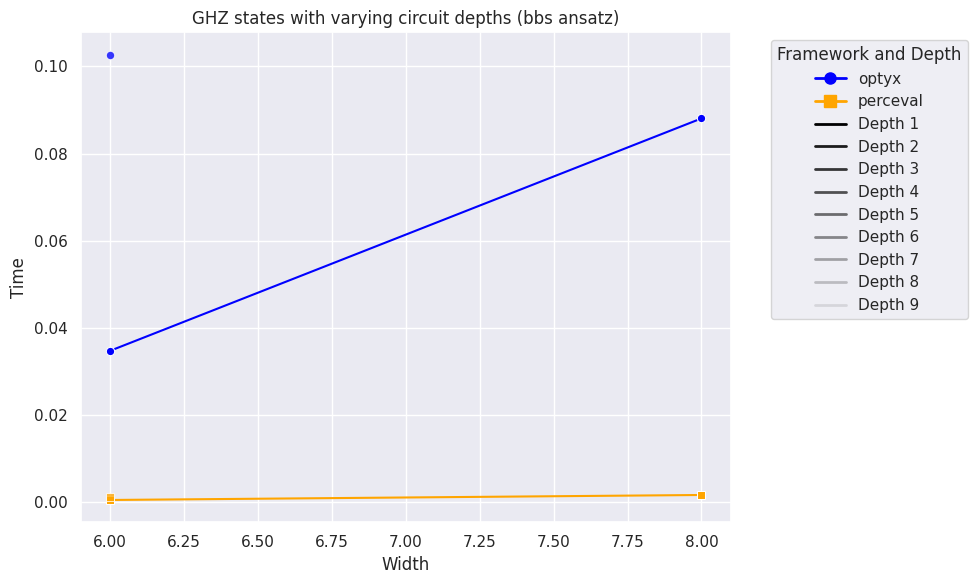

In [102]:
plot("GHZ", "bbs", "GHZ states with varying circuit depths (bbs ansatz)")

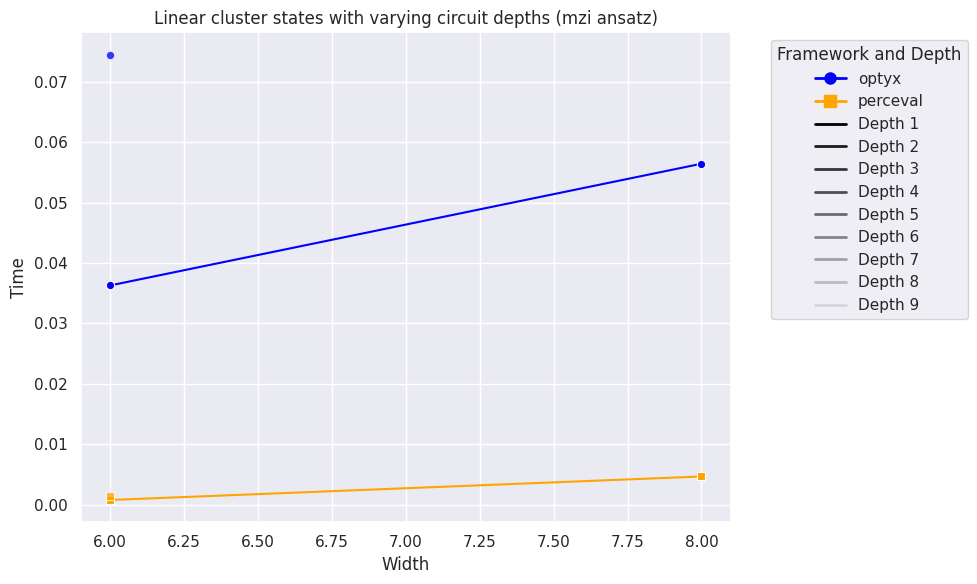

In [103]:
plot("Linear cluster state", "mzi", "Linear cluster states with varying circuit depths (mzi ansatz)")

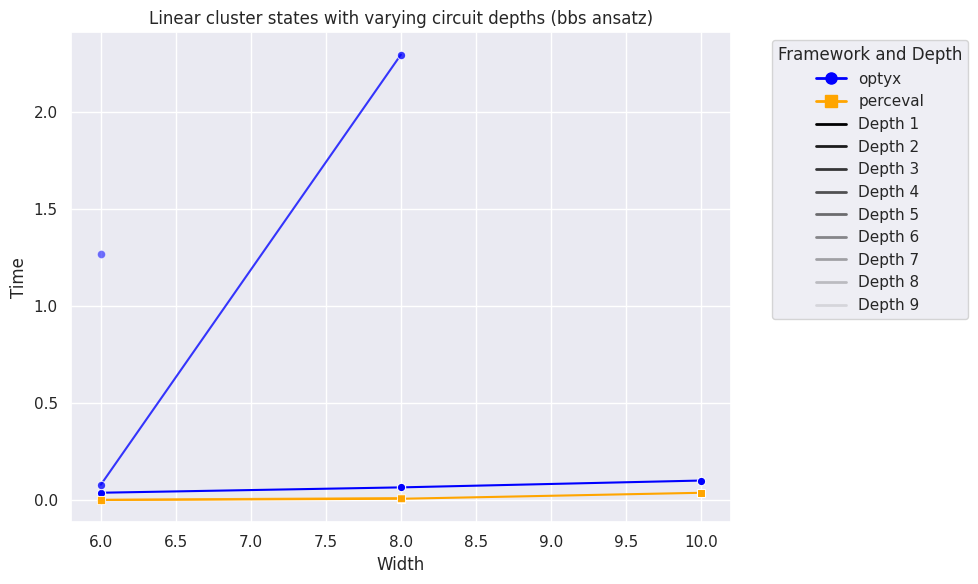

In [104]:
plot("Linear cluster state", "bbs", "Linear cluster states with varying circuit depths (bbs ansatz)")